In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import scipy

import torch
import mctorch.nn as mnn
import mctorch.optim as moptim

## Define the Dataset

In [2]:
# don't try to be too clever: it's hard to compute the vector field similarity if the beginning distribution is hard.
x1=np.random.uniform(low=0.0, high=1.0, size=2**12)
x2=np.random.uniform(low=0.0, high=1.0, size=2**12)
x3=np.random.uniform(low=0.0, high=1.0, size=2**12)
x4=np.random.uniform(low=0.0, high=1.0, size=2**12)
x5=np.random.uniform(low=0.0, high=1.0, size=2**12)
x6=np.random.uniform(low=0.0, high=1.0, size=2**12)
X6t = np.array([x1,x2,x3,x4,x5,x6])
X6 = X6t.transpose()

In [3]:
xs = [np.sqrt(x[0]) for x in X6]
ys = [np.sqrt(x[3]) for x in X6]
zs = [np.sqrt(x[5]) for x in X6]
Xt = np.array([xs,ys,zs])
X = Xt.transpose()
#X = np.random.multivariate_normal(np.array([0,0,0]), np.array([[1,0,0],[0,1,0],[0,0,1]]), size=2**12)
#Xt = X.transpose()

## Get the true class labels

In [4]:
def f(x):
    # I changed this by adding a -1/2 term (doesn't change the symmetries).
    term = x[0]**2+x[1]**2/2-x[1]*x[2]+x[2]**2/2-1/2
    return term

In [5]:
def f6(x):
    term = x[0] + x[3]/2 - np.sqrt(2)/2*x[4] + x[5]/2 - 1/2
    return term

In [6]:
def probs(x):
    term = 1/(1+np.exp(-f6(x)))
    return term

In [7]:
def getLabel(x, probs):
    if probs(x)>0.5:
        term = 1.0
    else:
        term = 0.0

    return term

In [8]:
labels = [getLabel(x,probs) for x in X6]

In [9]:
# proportion in the positive class.
len([1 for i in labels if i==1.0])/X6.shape[0]

0.637451171875

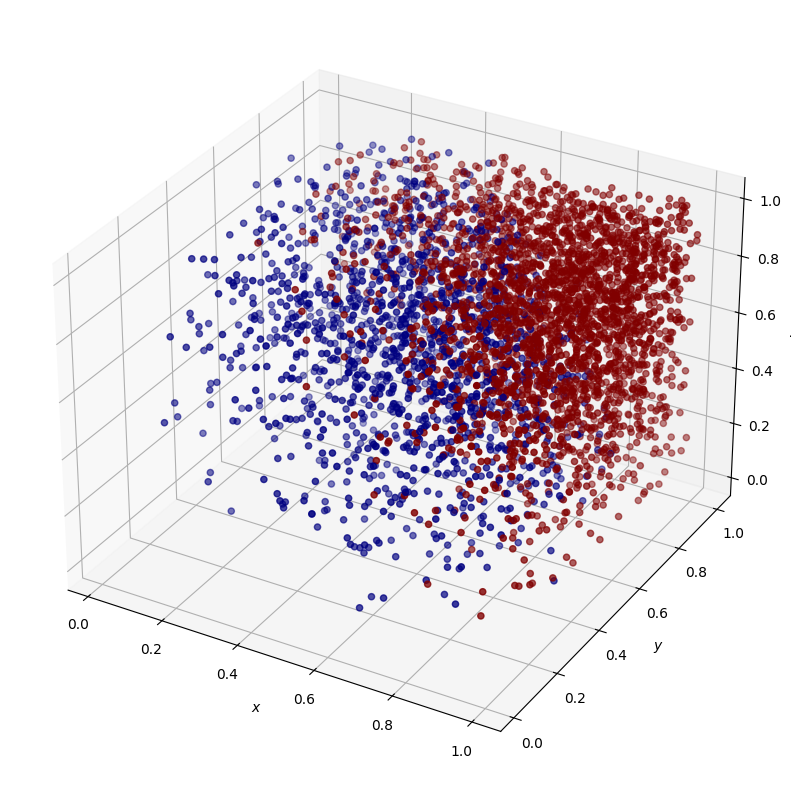

In [10]:
# Plot the dataset.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(Xt[0],Xt[1],Xt[2],c=labels,cmap="jet")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.show()

## Train a Logistic regression function to get the separating hyperplane

In [11]:
LG = LogisticRegression(random_state=0, max_iter=1000, penalty='l1', solver='saga')
LG.fit(X6,labels)

LogisticRegression(max_iter=1000, penalty='l1', random_state=0, solver='saga')

In [12]:
LG.coef_

array([[ 47.45577821,   0.33335519,   0.        ,  23.42999384,
        -33.61359493,  23.68584358]])

In [13]:
LG.intercept_

array([-23.63626246])

In [14]:
LG.score(X6,labels)

0.999267578125

In [15]:
# Here is what the decision function should be in the original coordinates.
def estProb(x):
    feats = np.array([x[0]**2,np.sqrt(2)*x[0]*x[1],np.sqrt(2)*x[0]*x[2],x[1]**2,np.sqrt(2)*x[1]*x[2],x[2]**2])
    zee = np.dot(LG.coef_,feats)[0] + LG.intercept_[0]
    term = 1/(1+np.exp(-zee))
    return term

## Learn the Symmetries from known Killing vectors

In [16]:
#grads = np.array([scipy.optimize.approx_fprime(point, probs) for point in X])
grads = np.array([scipy.optimize.approx_fprime(point, estProb) for point in X])

In [17]:
def myA2(X,grads):
    r1 = np.array([np.dot(np.array([0.0, -X[i][2], X[i][1]]), grads[i]) for i in range(len(grads))]) # x-axis rotation
    r2 = np.array([np.dot(np.array([X[i][2], 0.0, -X[i][0]]), grads[i]) for i in range(len(grads))]) # y-axis rotation
    r3 = np.array([np.dot(np.array([-X[i][1], X[i][0], 0.0]), grads[i]) for i in range(len(grads))]) # z-axis rotation
    myMat = np.array([r1,r2,r3]).transpose()
    return myMat

In [18]:
A2 = myA2(X,grads)

In [19]:
A2.shape

(4096, 3)

In [20]:
def tryDimV(extB, d, criterion=torch.nn.L1Loss(), optimizer=moptim.rAdagrad, n_epochs=5000):
    manifold_param = mnn.Parameter(manifold=mnn.Stiefel(extB.shape[1],d))
    Btensor = torch.tensor(extB).float() #extB.detach()
    
    def model(mat):
        term1 = torch.matmul(Btensor, mat.float())
        #term2 = torch.norm(term1)
        #return term2
        return term1
    
    y = torch.zeros((extB.shape[0],d))
    
    optimizer = optimizer(params = [manifold_param], lr=1e-2)
    #optimizer = moptim.rAdagrad(params = [manifold_param], lr=1e-2)
    #optimizer = moptim.rSGD(params = [manifold_param], lr=1e-2)
    #criterion = torch.nn.L1Loss() #torch.nn.MSELoss()
    for epoch in range(n_epochs):
        y_pred = model(manifold_param)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), manifold_param

In [21]:
t1 = tryDimV(A2, 1)

/home/ben/.local/lib/python3.12/site-packages/mctorch/nn/manifolds/stiefel.py:50: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  q, r = torch.qr(X)


In [22]:
t1

(0.0006787287420593202,
 Parameter containing:
 Parameter(Parameter([[ 0.0055],
            [-0.7076],
            [-0.7066]], requires_grad=True)))

In [23]:
# unfortunately, this term has to be calculated manually each time we get a new vector field estimate.
# that is, "term" needs to be adjusted every time.
#def integrand(x,y,z):
#    term = np.abs((2.828400*x**2*y*z-4.2428*z**2*x**2+2.828400*y**3*z-2.828400*y**2*z**2+2.828400*y*z**3-1.4144*z**4-1.414000*y**4+0.2e-3*x**3*z+0.20000e-3*y**2*x*z+0.2e-3*x*z**3-2.8284*x**4-4.2424*y**2*x**2+0.20000e-3*y*x*z**2+0.20000e-3*x**3*y+0.20000e-3*x*y**3)/np.sqrt((3.00022538*z**2*x**2+1.999961720*y**2*z**2+1.00026370*z**4-1.999961600*x**2*y*z-1.9999616*y**3*z-1.9999616*y*z**3+.99969802*y**4-0.2828000000e-3*y**2*x*z-0.2828e-3*x**3*z-0.2828e-3*x*z**3+1.99996168*x**4+2.99965970*y**2*x**2-0.282880000e-3*y*x*z**2-0.28288e-3*x**3*y-0.28288e-3*x*y**3)*(4*x**4+6*x**2*y**2-4*x**2*y*z+6*x**2*z**2+2*y**4-4*y**3*z+4*y**2*z**2-4*y*z**3+2*z**4)))
#    return term

In [24]:
#scipy.integrate.nquad(integrand, [[0,1],[0,1],[0,1]])